<a href="https://colab.research.google.com/github/soniya-2712/simple-demo/blob/main/happy_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install librosa soundfile


In [26]:
import os
import librosa
import numpy as np

# Your dataset path
dataset_path = '/content/drive/MyDrive/DogSounds/dataset/kaggle_dataset'
 # Adjust this if needed

# Map vocalization type to emotion
emotion_map = {
    'bark': 'happy',
    'growl': 'angry',
    'howl': 'sad',
    'whine': 'sad'
}


In [27]:
def extract_features(file_path, n_mfcc=13):
    try:
        y, sr = librosa.load(file_path, duration=3, offset=0.5)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_scaled = np.mean(mfcc.T, axis=0)
        return mfcc_scaled
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

features = []
labels = []

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if not os.path.isdir(folder_path):
        continue

    emotion_label = emotion_map.get(folder)
    if emotion_label is None:
        continue

    for file_name in os.listdir(folder_path):
        if file_name.endswith(".wav"):
            file_path = os.path.join(folder_path, file_name)
            mfcc = extract_features(file_path)
            if mfcc is not None:
                features.append(mfcc)
                labels.append(emotion_label)


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1847
  warnings.warn(
/tmp/ipython-input-27-1528753143.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, duration=3, offset=0.5)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
/tmp/ipython-input-27-1528753143.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, duration=3, offset=0.5)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audiore

In [28]:
def extract_features(file_path, n_mfcc=13):
    try:
        y, sr = librosa.load(file_path, duration=3.0)
        if len(y) < 2048:
            # Skip files that are too short
            print(f"Skipped (too short): {file_path}")
            return None
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_scaled = np.mean(mfcc.T, axis=0)
        return mfcc_scaled
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [29]:
features = []
labels = []

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if not os.path.isdir(folder_path):
        continue

    emotion_label = emotion_map.get(folder)
    if emotion_label is None:
        continue

    for file_name in os.listdir(folder_path):
        if file_name.endswith(".wav"):
            file_path = os.path.join(folder_path, file_name)
            mfcc = extract_features(file_path)
            if mfcc is not None:
                features.append(mfcc)
                labels.append(emotion_label)

X = np.array(features)
y = np.array(labels)

print("Feature shape:", X.shape)
print("Number of labels:", len(y))
print("Unique labels and counts:", np.unique(y, return_counts=True))


Feature shape: (401, 13)
Number of labels: 401
Unique labels and counts: (array(['angry', 'happy', 'sad'], dtype='<U5'), array([ 39, 314,  48]))


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix


In [31]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Encoded labels:", np.unique(y_encoded))
print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Encoded labels: [0 1 2]
Label mapping: {np.str_('angry'): np.int64(0), np.str_('happy'): np.int64(1), np.str_('sad'): np.int64(2)}


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


In [33]:
clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)


SVC(kernel='linear', probability=True)

In [34]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train the model
clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

# Predict on test data
y_pred = clf.predict(X_test)

# Print results
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

       angry       0.80      0.50      0.62         8
       happy       0.92      0.92      0.92        63
         sad       0.69      0.90      0.78        10

    accuracy                           0.88        81
   macro avg       0.80      0.77      0.77        81
weighted avg       0.88      0.88      0.87        81

Confusion Matrix:

[[ 4  4  0]
 [ 1 58  4]
 [ 0  1  9]]


In [35]:
!pip install imbalanced-learn


In [36]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Retrain classifier on balanced data
clf.fit(X_resampled, y_resampled)


SVC(kernel='linear', probability=True)

In [37]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

       angry       0.64      0.88      0.74         8
       happy       0.98      0.84      0.91        63
         sad       0.62      1.00      0.77        10

    accuracy                           0.86        81
   macro avg       0.75      0.91      0.80        81
weighted avg       0.90      0.86      0.87        81



In [39]:
from google.colab import files
uploaded = files.upload()  # Upload a .wav file

file_path = list(uploaded.keys())[0]
features = extract_features(file_path)

if features is not None:
    features = np.array([features])
    pred = clf.predict(features)
    emotion = label_encoder.inverse_transform(pred)
    print(" Predicted emotion:", emotion[0])


Saving bark (465).wav to bark (465).wav
 Predicted emotion: happy


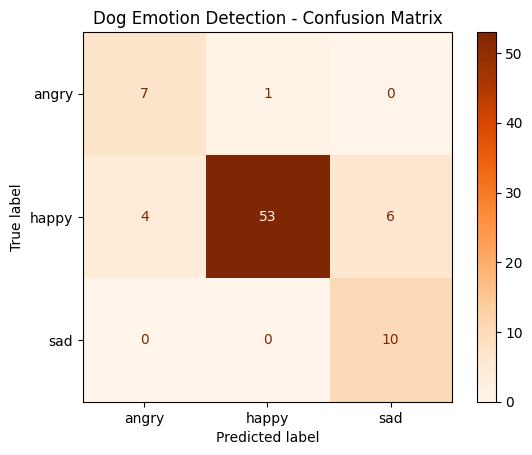

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(
    clf, X_test, y_test, display_labels=label_encoder.classes_, cmap='Oranges'
)
plt.title("Dog Emotion Detection - Confusion Matrix")
plt.show()


In [41]:
import joblib

# Save model and label encoder
joblib.dump(clf, '/content/drive/MyDrive/dog_emotion_classifier.pkl')
joblib.dump(label_encoder, '/content/drive/MyDrive/label_encoder.pkl')


['/content/drive/MyDrive/label_encoder.pkl']

In [42]:
clf = joblib.load('/content/drive/MyDrive/dog_emotion_classifier.pkl')
label_encoder = joblib.load('/content/drive/MyDrive/label_encoder.pkl')


In [43]:
from google.colab import files
import numpy as np

uploaded = files.upload()

file_path = list(uploaded.keys())[0]
features = extract_features(file_path)

if features is not None:
    features = np.array([features])
    pred = clf.predict(features)
    emotion = label_encoder.inverse_transform(pred)
    print("🎧 Predicted emotion:", emotion[0])


Saving growl (1).wav to growl (1).wav
🎧 Predicted emotion: angry


In [44]:
from google.colab import files
import numpy as np

uploaded = files.upload()

file_path = list(uploaded.keys())[0]
features = extract_features(file_path)

if features is not None:
    features = np.array([features])
    pred = clf.predict(features)
    emotion = label_encoder.inverse_transform(pred)
    print("🎧 Predicted emotion:", emotion[0])


Saving howl (5).wav to howl (5).wav
🎧 Predicted emotion: sad


In [45]:
from google.colab import files
import numpy as np

uploaded = files.upload()

file_path = list(uploaded.keys())[0]
features = extract_features(file_path)

if features is not None:
    features = np.array([features])
    pred = clf.predict(features)
    emotion = label_encoder.inverse_transform(pred)
    print("🎧 Predicted emotion:", emotion[0])


Saving whine (2).wav to whine (2).wav
🎧 Predicted emotion: sad
